In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
import scipy.io
import networkx as nx
import community as community_louvain
from networkx.algorithms.community import girvan_newman
from itertools import combinations
import itertools
from itertools import islice
import os
from networkx.algorithms.community import modularity
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D  # For 3D visualization

In [2]:
mat_data= scipy.io.loadmat('dataMSc.mat')
data= mat_data['data']

In [3]:
data.shape

(1, 98)

## Fisher's r-to-z tranformation for converting to normal distribution:

In [4]:
def fisher_r_to_z(r):
    return np.arctanh(r)

In [5]:
num_subjects = data.shape[1]
num_contrasts = 3  # HbO, HbR, HbT
num_channels = 64

In [6]:
average_correlation_matrices = np.zeros((num_subjects, num_channels, num_channels, num_contrasts))

In [7]:
for i in range(num_subjects): # range will return a list from 0 to 97, hence i-1 will be adjusted to i
    subject_data = data[0, i]
    num_runs = len(subject_data[0])
    
    if num_runs == 0:
        continue  # No data for this subject, 'continue' is used to start the next iteration

    for contrast in range(num_contrasts):
        z_sum = np.zeros((num_channels, num_channels))
        count = np.zeros((num_channels, num_channels))
        
        for run in range(num_runs):
            run_data = subject_data[0, run]
            
            if run_data.size == 0:
                continue  # Empty run data
            
            correlation_matrix = run_data[:, :, contrast]
            valid = ~np.isnan(correlation_matrix) # a mask to identify indices with not (~) NaN values
            
            z_values = np.zeros_like(correlation_matrix)
            z_values[valid] = fisher_r_to_z(correlation_matrix[valid])
            
            z_sum[valid] += z_values[valid]
            count[valid] += 1
        
        # Avoid division by zero
        valid_counts = count > 0
        z_avg = np.zeros_like(z_sum)
        z_avg[valid_counts] = z_sum[valid_counts] / count[valid_counts]
        
        average_correlation_matrices[i, :, :, contrast] = z_avg

In [8]:
average_correlation_matrices.shape

(98, 64, 64, 3)

In [9]:
average_correlation_matrices[11,:,:,2]

array([[ 0.        ,  0.36504995,  0.29540802, ...,  0.        ,
        -0.13546032,  0.        ],
       [ 0.36504995,  0.        ,  0.11869422, ...,  0.        ,
        -0.1036168 ,  0.        ],
       [ 0.29540802,  0.11869422,  0.        , ...,  0.        ,
        -0.18546139,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13546032, -0.1036168 , -0.18546139, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [10]:
# Initialize the sum and count matrices
sum_matrix = np.zeros((64, 64, 3))
count_matrix = np.zeros((64, 64, 3))

# Iterate over each subject
for subject_matrix in average_correlation_matrices:
    # Accumulate the sum of matrices, replacing NaNs with zeros to not affect the sum
    sum_matrix += np.nan_to_num(subject_matrix)
    # Count valid (non-NaN) data points for each element in the matrices
    count_matrix += ~np.isnan(subject_matrix)

# Compute the average matrix by dividing the sum by the count for each element
average_matrix = sum_matrix / count_matrix

In [11]:
average_matrix.shape

(64, 64, 3)

# Newman Girvan method

In [15]:
def load_anatomical_mappings(file_path):
    # Load the anatomical locations from the CSV file
    anatomical_loc_df = pd.read_csv(file_path)
    
    # Create dictionaries for mapping channel to anatomical information
    channel_to_label = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Label_name']))  # Adjust for zero-based index
    channel_to_lobe = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Lobe']))  # Adjust for zero-based index
    channel_to_hem = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Hemisphere']))  # Adjust for zero-based index
    
    return channel_to_label, channel_to_lobe, channel_to_hem

def detect_communities(graph):
    # Detect communities using the Girvan-Newman algorithm
    comp = girvan_newman(graph)
    
    # Return the first complete partition found by the algorithm
    for communities in comp:
        return list(communities)

def calculate_modularity(graph, communities):
    # Calculate modularity score
    mod_score = modularity(graph, communities)
    return mod_score

def save_final_communities(contrast_id, communities, channel_to_label, channel_to_lobe, channel_to_hem):
    community_data = []
    for community_id, community in enumerate(communities):
        for node in sorted(community):
            label_name = channel_to_label.get(int(node), 'Unknown')
            lobe = channel_to_lobe.get(int(node), 'Unknown')
            hemisphere = channel_to_hem.get(int(node), 'Unknown')
            community_data.append({
                'contrast_id': contrast_id,
                'community_id': community_id,
                'node': node,
                'label_name': label_name,
                'lobe': lobe,
                'hemisphere': hemisphere
            })
    
    # Convert to DataFrame and save to CSV
    community_df = pd.DataFrame(community_data)
    community_df.to_csv(f'communities_girvan_newman/average_matrix_contrast_{contrast_id}_communities.csv', index=False)
    
    print(f"Final communities for contrast {contrast_id} saved to 'communities_girvan_newman/average_matrix_contrast_{contrast_id}_communities.csv'.")

def main():
    anatomical_file_path = 'fNIRS channels anatomical labels.csv'
    channel_to_label, channel_to_lobe, channel_to_hem = load_anatomical_mappings(anatomical_file_path)
    
    os.makedirs('communities_girvan_newman', exist_ok=True)
    
    num_contrasts = 3 
    num_nodes = average_matrix.shape[0] 
    
    for contrast in range(num_contrasts):
        # Create the graph from the average correlation matrix for each contrast
        avg_corr_matrix = average_matrix[:, :, contrast]
        graph = nx.Graph()
            
        for i in range(avg_corr_matrix.shape[0]):
            for j in range(i + 1, avg_corr_matrix.shape[1]):
                if not np.isnan(avg_corr_matrix[i, j]) and avg_corr_matrix[i, j] > 0.3:
                    graph.add_edge(i, j, weight=avg_corr_matrix[i, j])
        
        # Detect communities directly on the average graph
        communities = detect_communities(graph)
        
        # Calculate and print modularity
        mod_score = calculate_modularity(graph, communities)
        print(f"Modularity for contrast {contrast + 1}: {mod_score}")
        
        # Save the final communities directly
        save_final_communities(contrast + 1, communities, channel_to_label, channel_to_lobe, channel_to_hem)

if __name__ == "__main__":
    main()

Modularity for contrast 1: 0.7573466735523776
Final communities for contrast 1 saved to 'communities_girvan_newman/average_matrix_contrast_1_communities.csv'.
Modularity for contrast 2: 0.6300388248986752
Final communities for contrast 2 saved to 'communities_girvan_newman/average_matrix_contrast_2_communities.csv'.
Modularity for contrast 3: 0.7156729417044676
Final communities for contrast 3 saved to 'communities_girvan_newman/average_matrix_contrast_3_communities.csv'.


# Louvain method

In [16]:
def load_anatomical_mappings(file_path):
    # Load the anatomical locations from the CSV file
    anatomical_loc_df = pd.read_csv(file_path)
    
    # Create dictionaries for mapping channel to anatomical information
    channel_to_label = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Label_name']))  # Adjust for zero-based index
    channel_to_lobe = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Lobe']))  # Adjust for zero-based index
    channel_to_hem = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Hemisphere']))  # Adjust for zero-based index
    
    return channel_to_label, channel_to_lobe, channel_to_hem

def detect_and_save_communities(contrast_id, graph, channel_to_label, channel_to_lobe, channel_to_hem, resolution=1.0):
    if graph is None:
        print(f"Skipping community detection for contrast {contrast_id} due to missing data.")
        return
    
    # Detect communities using the Louvain algorithm with a resolution parameter
    partition = community_louvain.best_partition(graph, resolution=resolution)
    
    # Organize nodes by community
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = set()
        communities[community_id].add(node)
    
    # Prepare to save the communities
    community_data = []
    for community_id, community in communities.items():
        for node in community:
            label_name = channel_to_label.get(int(node), 'Unknown')
            lobe = channel_to_lobe.get(int(node), 'Unknown')
            hemisphere = channel_to_hem.get(int(node), 'Unknown')
            community_data.append({
                'contrast_id': contrast_id,
                'community_id': community_id,
                'node': node,
                'label_name': label_name,
                'lobe': lobe,
                'hemisphere': hemisphere
            })
    
    # Convert to DataFrame and save to CSV
    community_df = pd.DataFrame(community_data)
    community_df.to_csv(f'communities_louvain/average_contrast_{contrast_id}_communities.csv', index=False)

    # Compute Modularity
    mod = community_louvain.modularity(partition, graph)
    print(f"Modularity for contrast {contrast_id}: {mod}")
    
def main():
    anatomical_file_path = 'fNIRS channels anatomical labels.csv'
    channel_to_label, channel_to_lobe, channel_to_hem = load_anatomical_mappings(anatomical_file_path)
    
    os.makedirs('communities_louvain', exist_ok=True)
    
    num_contrasts = 3  
    for contrast in range(num_contrasts):
        # Create the graph from the average correlation matrix for each contrast
        avg_corr_matrix = average_matrix[:, :, contrast]
        graph = nx.Graph()
        
        for i in range(avg_corr_matrix.shape[0]):
            for j in range(i + 1, avg_corr_matrix.shape[1]):
                if not np.isnan(avg_corr_matrix[i, j]) and avg_corr_matrix[i, j] > 0.3:
                    graph.add_edge(i, j, weight=avg_corr_matrix[i, j])
        
        # Detect and save communities for the average graph
        detect_and_save_communities(contrast + 1, graph, channel_to_label, channel_to_lobe, channel_to_hem)

if __name__ == "__main__":
    main()

Modularity for contrast 1: 0.7644466096914828
Modularity for contrast 2: 0.6861348465726842
Modularity for contrast 3: 0.7434843568711099


# Isomap

/Users/paruljain/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


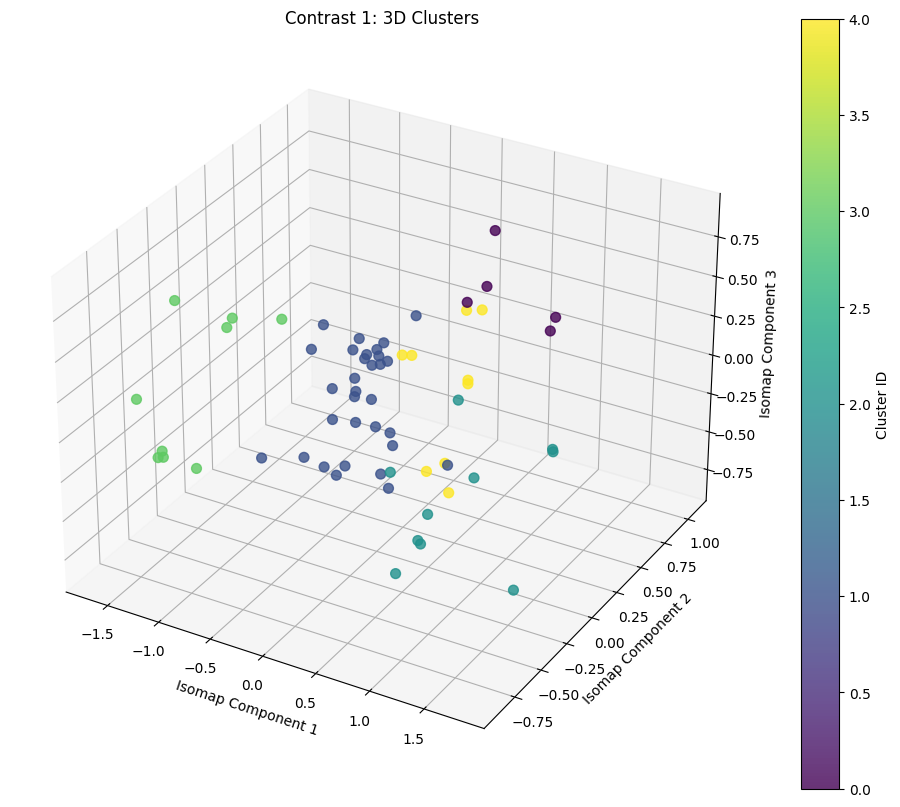

/Users/paruljain/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


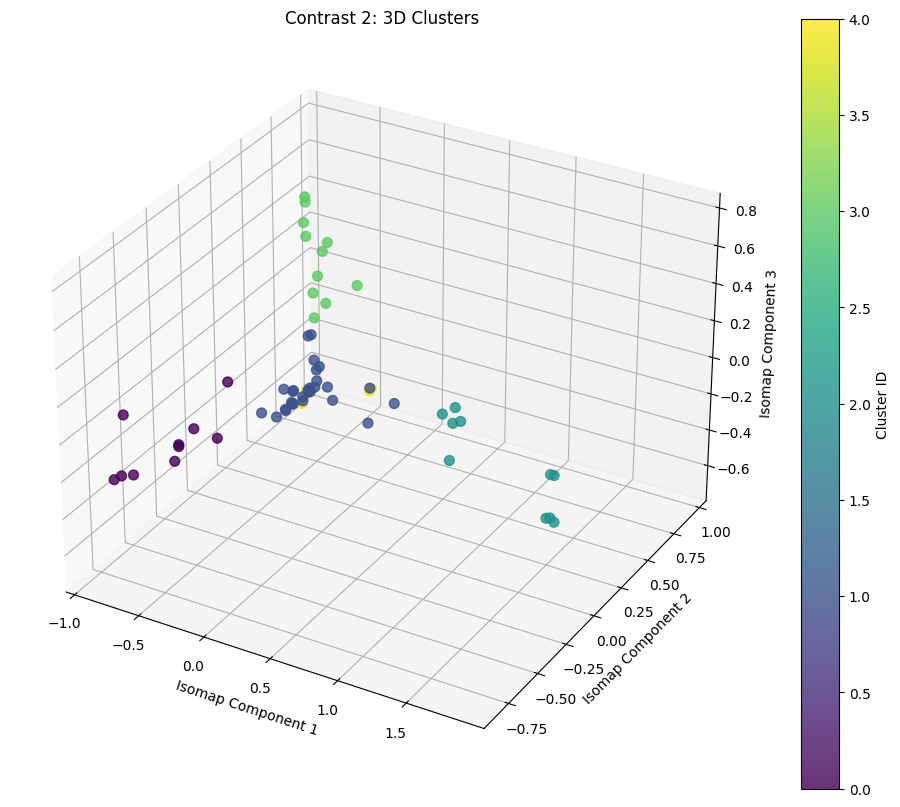

/Users/paruljain/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


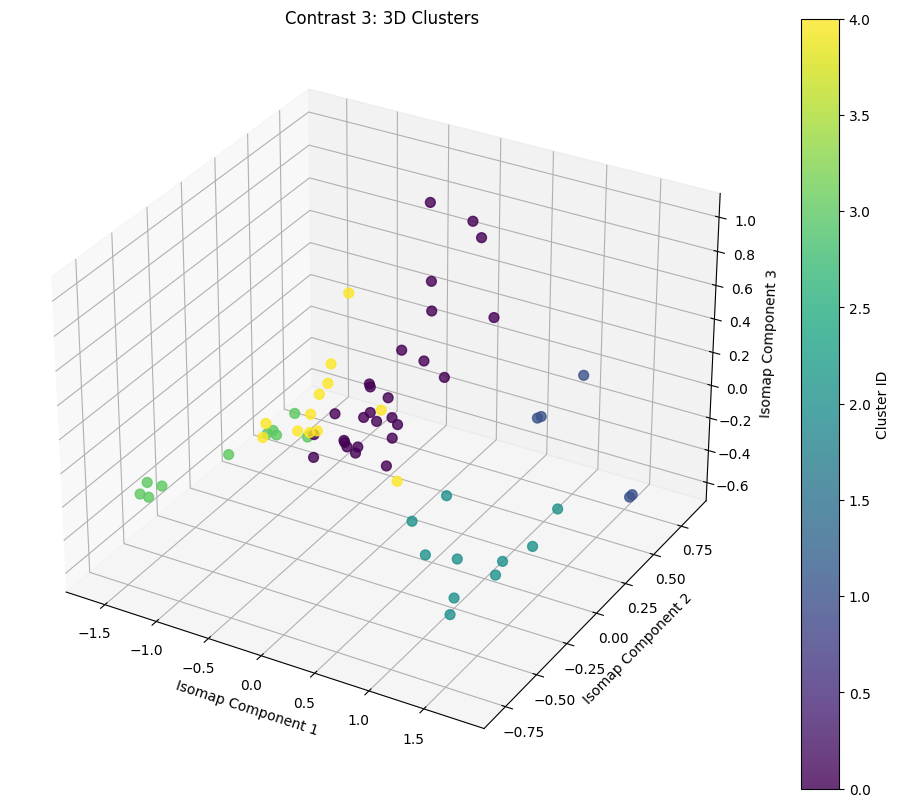

In [14]:
def load_anatomical_mappings(file_path):
    # Load the anatomical locations from the CSV file
    anatomical_loc_df = pd.read_csv(file_path)
    
    # Create dictionaries for mapping channel to anatomical information
    channel_to_label = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Label_name']))  # Adjust for zero-based index
    channel_to_lobe = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Lobe']))  # Adjust for zero-based index
    channel_to_hem = dict(zip(anatomical_loc_df['Channel'] - 1, anatomical_loc_df['Hemisphere']))  # Adjust for zero-based index
    
    return channel_to_label, channel_to_lobe, channel_to_hem

def visualize_clusters_3d(reduced_data, labels, title='3D Cluster Visualization'):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot in 3D, coloring points by cluster labels
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=labels, cmap='viridis', s=50, alpha=0.8)
    
    # Adding a colorbar to indicate which color corresponds to which cluster
    fig.colorbar(scatter, label='Cluster ID')
    
    ax.set_title(title)
    ax.set_xlabel('Isomap Component 1')
    ax.set_ylabel('Isomap Component 2')
    ax.set_zlabel('Isomap Component 3')
    plt.show()

def detect_and_save_communities(contrast_id, avg_corr_matrix, channel_to_label, channel_to_lobe, channel_to_hem):
    if avg_corr_matrix is None:
        print(f"Skipping community detection for contrast {contrast_id} due to missing data.")
        return
    
    # Apply Isomap for dimensionality reduction with 3 components
    isomap = Isomap(n_neighbors=5, n_components=3)
    reduced_data = isomap.fit_transform(avg_corr_matrix)
    
    # Apply KMeans clustering to identify communities
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(reduced_data)
    labels = kmeans.labels_
    
    # Visualize the clusters in 3D
    visualize_clusters_3d(reduced_data, labels, title=f'Contrast {contrast_id}: 3D Clusters')
    
    # Prepare to save the communities
    community_data = []
    for node, community_id in enumerate(labels):
        label_name = channel_to_label.get(int(node), 'Unknown')
        lobe = channel_to_lobe.get(int(node), 'Unknown')
        hemisphere = channel_to_hem.get(int(node), 'Unknown')
        community_data.append({
            'contrast_id': contrast_id,
            'community_id': community_id,
            'node': node,
            'label_name': label_name,
            'lobe': lobe,
            'hemisphere': hemisphere
        })
    
    # Convert to DataFrame
    community_df = pd.DataFrame(community_data)
    
    # Sort the DataFrame by community_id
    community_df.sort_values(by='community_id', inplace=True)
    
    # Save to CSV
    community_df.to_csv(f'communities_isomap/average_contrast_{contrast_id}_communities.csv', index=False)

def main():
    anatomical_file_path = 'fNIRS channels anatomical labels.csv'
    channel_to_label, channel_to_lobe, channel_to_hem = load_anatomical_mappings(anatomical_file_path)
    
    os.makedirs('communities_isomap', exist_ok=True)
    
    # Assuming average_matrix is already defined and loaded
    for contrast in range(3):  # Assuming 3 contrasts
        avg_corr_matrix = average_matrix[:, :, contrast]
        if np.isnan(avg_corr_matrix).all():
            print(f"Skipping contrast {contrast + 1} due to all values being NaN.")
            continue
        
        # Detect and save communities for the average graph
        detect_and_save_communities(contrast + 1, avg_corr_matrix, channel_to_label, channel_to_lobe, channel_to_hem)

if __name__ == "__main__":
    main()

## NMI values

In [5]:
#Contrast 3 (HbT)

girvan_newman_df = pd.read_csv('communities_girvan_newman/contrast_3_final_communities.csv')
louvain_df = pd.read_csv('communities_louvain/contrast_3_final_communities.csv')
isomap_df = pd.read_csv('communities_isomap/contrast_3_final_communities.csv')

# Extract the relevant columns
gn_communities = girvan_newman_df[['node', 'community_id']]
louvain_communities = louvain_df[['node', 'community_id']]
isomap_communities = isomap_df[['node', 'community_id']]

# Merge dataframes to ensure nodes are aligned
merged_df = gn_communities.merge(louvain_communities, on='node', suffixes=('_gn', '_louvain'))
merged_df = merged_df.merge(isomap_communities, on='node')

# Extract the community labels for comparison
gn_labels = merged_df['community_id_gn'].tolist()
louvain_labels = merged_df['community_id_louvain'].tolist()
isomap_labels = merged_df['community_id'].tolist()  

# Calculate NMI 
nmi_gn_louvain = normalized_mutual_info_score(gn_labels, louvain_labels)

print(f'NMI between Girvan-Newman and Louvain: {nmi_gn_louvain}')

NMI between Girvan-Newman and Louvain: 0.747993767131454


In [7]:
# Contrast 1 (HbO)

girvan_newman_df = pd.read_csv('communities_girvan_newman/contrast_1_final_communities.csv')
louvain_df = pd.read_csv('communities_louvain/contrast_1_final_communities.csv')
isomap_df = pd.read_csv('communities_isomap/contrast_1_final_communities.csv')

# Extract the relevant columns
gn_communities = girvan_newman_df[['node', 'community_id']]
louvain_communities = louvain_df[['node', 'community_id']]
isomap_communities = isomap_df[['node', 'community_id']]

# Merge dataframes to ensure nodes are aligned
merged_df = gn_communities.merge(louvain_communities, on='node', suffixes=('_gn', '_louvain'))
merged_df = merged_df.merge(isomap_communities, on='node')

# Extract the community labels for comparison
gn_labels = merged_df['community_id_gn'].tolist()
louvain_labels = merged_df['community_id_louvain'].tolist()
isomap_labels = merged_df['community_id'].tolist()  # from the isomap_df

# Calculate NMI between each pair of methods
nmi_gn_louvain = normalized_mutual_info_score(gn_labels, louvain_labels)

print(f'NMI between Girvan-Newman and Louvain: {nmi_gn_louvain}')

NMI between Girvan-Newman and Louvain: 0.7978565199243514


In [8]:
# Contrast 2 (HbR)

girvan_newman_df = pd.read_csv('communities_girvan_newman/contrast_2_final_communities.csv')
louvain_df = pd.read_csv('communities_louvain/contrast_2_final_communities.csv')
isomap_df = pd.read_csv('communities_isomap/contrast_2_final_communities.csv')

# Extract the relevant columns
gn_communities = girvan_newman_df[['node', 'community_id']]
louvain_communities = louvain_df[['node', 'community_id']]
isomap_communities = isomap_df[['node', 'community_id']]

# Merge dataframes to ensure nodes are aligned
merged_df = gn_communities.merge(louvain_communities, on='node', suffixes=('_gn', '_louvain'))
merged_df = merged_df.merge(isomap_communities, on='node')

# Extract the community labels for comparison
gn_labels = merged_df['community_id_gn'].tolist()
louvain_labels = merged_df['community_id_louvain'].tolist()
isomap_labels = merged_df['community_id'].tolist()  # from the isomap_df

# Calculate NMI 
nmi_gn_louvain = normalized_mutual_info_score(gn_labels, louvain_labels)

print(f'NMI between Girvan-Newman and Louvain: {nmi_gn_louvain}')

NMI between Girvan-Newman and Louvain: 0.7750596268156182


In [5]:
# Load the co-occurrence matrix from the CSV file
cooccurrence_matrix = pd.read_csv('cooccurrence_matrix_contrast_3_louvain.csv', index_col=0)

# Display the first few rows to verify the data
print(cooccurrence_matrix.head())

    0   1   2   3  4   5   6   7   8  9  ...  54  55  56  57  58  59  60  61  \
0   0  49  52  41  4   4   7   4   3  7  ...  12  13   6   8   7   3   2   6   
1  49   0  45  39  4   4   4   3   3  7  ...  12  10   6   6   5   2   3   7   
2  52  45   0  53  4   4   5   4   3  4  ...   8   8   4   7   2   3   2   8   
3  41  39  53   0  4   4   4   4   4  6  ...   8   7   3   4   1   4   4   6   
4   4   4   4   4  0  65  60  65  58  9  ...   1   7   2   2   6   6   4   3   

   62  63  
0   8  11  
1   4  10  
2  11  17  
3  10  17  
4   3   2  

[5 rows x 64 columns]


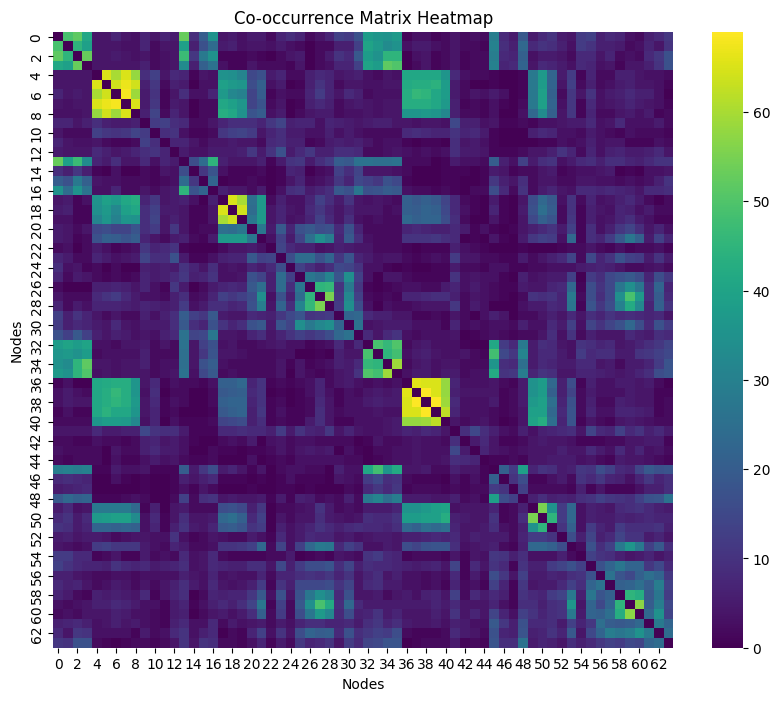

In [6]:
# Create a heatmap to visualize the co-occurrence matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence_matrix, cmap='viridis', annot=False, fmt="d")

# Add labels and title
plt.title('Co-occurrence Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')

# Show the plot
plt.show()